In [1]:
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   

In [2]:
rdd = spark.read.csv('datasets/diabetes.csv')

In [3]:
import pandas as pd

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV # para o grid search
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline # para o pipeline

In [5]:
dataset = pd.DataFrame(rdd.collect(), columns=['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'])

In [6]:
dataset

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
# separando os atributos e a classe do dataset
array = dataset.values
X = array[:,0:8]
Y = array[:,8]

# definindo o tamanho do conjunto de teste
test_size = 0.20 

# A semente (seed) pode ser qualquer número, e garante que os resultados possam ser reproduzidos de forma idêntica toda vez que o script for rodado. 
# Isto é muito importante quando trabalhamos com modelos ou métodos que utilizam de algum tipo de aleatoriedade.
seed = 7

# particionando em conjuntos de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [8]:
# definindo a métrica de avaliação dos algoritmos
scoring = 'accuracy'
# scoring = 'roc_auc'

kfold = KFold(n_splits=10)

In [9]:
model = KNeighborsClassifier()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.7101533580116342


In [16]:
# criação de outro modelo alterando o tipo de distância
model = KNeighborsClassifier(metric = 'manhattan')
# print(model.get_params())
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.7216552088841882


In [17]:
# criação de outro modelo alterando o valor de k
model = KNeighborsClassifier(n_neighbors = 7)
# print(model.get_params())
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.718244315177155


In [18]:
model = DecisionTreeClassifier(random_state=7)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.6758593336858805


In [20]:
# criando o modelo já com os parâmetros desejados
model = DecisionTreeClassifier(max_depth = None, # profundidade máxima - inteiro ou "None" (sem limite). Valores muito altos podem causar overviffing e muito baixos, underfitting.
                             criterion = 'entropy',
                             random_state=7) # critério de medição de qualidade de um particionamento {“gini”, “entropy”}, default=”gini”.

# imprimindo os parâmetros do modelo
# print(model.get_params())

results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.7066102591221576


In [21]:
model = GaussianNB()
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.7508196721311474


In [22]:
model = SVC(gamma='auto')
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.656292966684294


In [23]:
model = SVC(gamma='auto', kernel = 'linear')
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print(results.mean())

0.7768376520359598


KNN: 0.710153 (0.064599)
CART: 0.687335 (0.052398)
NB: 0.750820 (0.050575)
SVM: 0.656293 (0.044581)
LR: 0.773559 (0.060644)


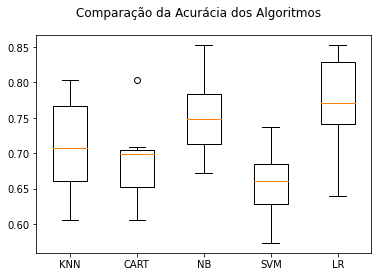

In [24]:
np.random.seed(7) # definindo uma seed global

# preparando os modelos
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('LR', LogisticRegression(max_iter=200)))

# avaliando um modelo por vez
results = []
names = []
scoring = 'accuracy'
folds = 10

for name, model in models:
  kfold = KFold(n_splits=folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
  print(msg)

# boxplot de comparação dos algoritmos
fig = plt.figure() 
fig.suptitle('Comparação da Acurácia dos Algoritmos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

ScaledKNN: 0.718297 (0.071563)
ScaledCART: 0.684082 (0.052059)
ScaledNB: 0.750820 (0.050575)
ScaledSVM: 0.752565 (0.064295)
ScaledLR: 0.778424 (0.061895)


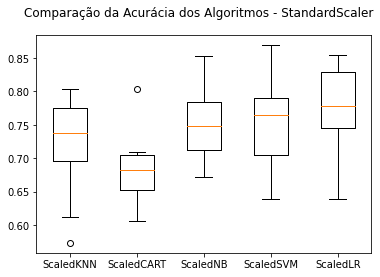

In [26]:
np.random.seed(7) # definindo uma seed global

# Pipelines para padronização do dataset e aplicação do modelo
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(max_iter=200))])))

results = []
names = []

# Aplicação dos pipelines
for name, model in pipelines:
    kfold = KFold(n_splits=folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot de comparação dos algoritmos
fig = plt.figure() 
fig.suptitle('Comparação da Acurácia dos Algoritmos - StandardScaler') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

NormKNN: 0.718271 (0.072688)
NormCART: 0.685722 (0.052430)
NormNB: 0.750820 (0.050575)
NormSVM: 0.758884 (0.054881)
NormLR: 0.765362 (0.066363)


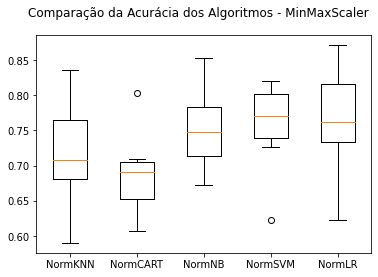

In [27]:
np.random.seed(7) # definindo uma seed global

# Pipelines para madronização do dataset e aplicação do modelo
pipelines = []
pipelines.append(('NormKNN', Pipeline([('MinMaxScaler', MinMaxScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('NormCART', Pipeline([('MinMaxScaler', MinMaxScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('NormNB', Pipeline([('MinMaxScaler', MinMaxScaler()),('NB', GaussianNB())])))
pipelines.append(('NormSVM', Pipeline([('MinMaxScaler', MinMaxScaler()),('SVM', SVC(gamma='auto'))])))
pipelines.append(('NormLR', Pipeline([('MinMaxScaler', MinMaxScaler()),('LR', LogisticRegression(max_iter=200))])))


results = []
names = []

# Aplicação dos pipelines
for name, model in pipelines:
  kfold = KFold(n_splits=folds)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

# boxplot de comparação dos algoritmos
fig = plt.figure() 
fig.suptitle('Comparação da Acurácia dos Algoritmos - MinMaxScaler') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

In [28]:
# Tuning do KNN

# padronização dos dados
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# hiperparâmetros que serão avaliados
k = [1,3,5,7,9,11,13,15,17,19,21]
distancias = ["euclidean", "manhattan", "minkowski"]
param_grid = dict(n_neighbors=k, metric=distancias)

# modelo
model = KNeighborsClassifier()
kfold = KFold(n_splits=10)

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_)) 

# imprime todos os resultados
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: 0.747329 usando {'metric': 'manhattan', 'n_neighbors': 17}
0.702036 (0.075358): {'metric': 'euclidean', 'n_neighbors': 1}
0.734611 (0.068286): {'metric': 'euclidean', 'n_neighbors': 3}
0.713432 (0.067707): {'metric': 'euclidean', 'n_neighbors': 5}
0.731253 (0.069739): {'metric': 'euclidean', 'n_neighbors': 7}
0.734506 (0.069032): {'metric': 'euclidean', 'n_neighbors': 9}
0.737652 (0.067802): {'metric': 'euclidean', 'n_neighbors': 11}
0.734400 (0.074541): {'metric': 'euclidean', 'n_neighbors': 13}
0.729376 (0.084487): {'metric': 'euclidean', 'n_neighbors': 15}
0.729455 (0.067497): {'metric': 'euclidean', 'n_neighbors': 17}
0.726150 (0.072579): {'metric': 'euclidean', 'n_neighbors': 19}
0.724484 (0.071632): {'metric': 'euclidean', 'n_neighbors': 21}
0.677578 (0.052071): {'metric': 'manhattan', 'n_neighbors': 1}
0.693866 (0.060109): {'metric': 'manhattan', 'n_neighbors': 3}
0.708408 (0.064635): {'metric': 'manhattan', 'n_neighbors': 5}
0.726362 (0.066480): {'metric': 'manhattan', 

In [29]:
# Tuning do SVM

# padronização dos dados
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# hiperparâmetros que serão avaliados
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

# modelo
model = SVC(gamma='auto')
kfold = KFold(n_splits=10)

# busca exaustiva de hiperparâmetros com GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# imprime o melhor resultado
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_)) 

# imprime todos os resultados
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f): %r" % (mean, stdev, param))

Melhor: 0.780090 usando {'C': 0.1, 'kernel': 'linear'}
0.780090 (0.055426): {'C': 0.1, 'kernel': 'linear'}
0.714860 (0.065600): {'C': 0.1, 'kernel': 'poly'}
0.711713 (0.047940): {'C': 0.1, 'kernel': 'rbf'}
0.767002 (0.059276): {'C': 0.1, 'kernel': 'sigmoid'}
0.780063 (0.060190): {'C': 0.3, 'kernel': 'linear'}
0.732893 (0.056653): {'C': 0.3, 'kernel': 'poly'}
0.754045 (0.067017): {'C': 0.3, 'kernel': 'rbf'}
0.755632 (0.060127): {'C': 0.3, 'kernel': 'sigmoid'}
0.778451 (0.061394): {'C': 0.5, 'kernel': 'linear'}
0.736118 (0.072612): {'C': 0.5, 'kernel': 'poly'}
0.754098 (0.069671): {'C': 0.5, 'kernel': 'rbf'}
0.755605 (0.049514): {'C': 0.5, 'kernel': 'sigmoid'}
0.778451 (0.061394): {'C': 0.7, 'kernel': 'linear'}
0.741036 (0.063252): {'C': 0.7, 'kernel': 'poly'}
0.749233 (0.061007): {'C': 0.7, 'kernel': 'rbf'}
0.740931 (0.046575): {'C': 0.7, 'kernel': 'sigmoid'}
0.778451 (0.061394): {'C': 0.9, 'kernel': 'linear'}
0.734558 (0.062042): {'C': 0.9, 'kernel': 'poly'}
0.747647 (0.066258): {'C': 

In [30]:
# https://www.mikulskibartosz.name/how-to-set-the-global-random_state-in-scikit-learn/
np.random.seed(7) # definindo uma seed global 

# padronização os dados de treino
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# criando um modelo com a melhor configuração até o momento
model = SVC(C=0.1, kernel='linear')
model.fit(rescaledX, Y_train)

# padronização dos dados de teste
rescaledTestX = scaler.transform(X_test)

# predição
predictions = model.predict(rescaledTestX)

# estimando a acurácia no conjunto de teste
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.7922077922077922
[[91  6]
 [26 31]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        97
           1       0.84      0.54      0.66        57

    accuracy                           0.79       154
   macro avg       0.81      0.74      0.76       154
weighted avg       0.80      0.79      0.78       154

